In [1]:
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, CenterCrop, Grayscale
import matplotlib.pyplot as plt
import time
import dataset as data
import model as md
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(DEVICE))

C:\Users\Wonjoon_LAB\PycharmProjects\AIGS538_Carplate_letter_sequence_geneneration\venv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Wonjoon_LAB\PycharmProjects\AIGS538_Carplate_letter_sequence_geneneration\venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


Using cuda device


In [2]:
## Hyperparameters
Batch_size = 128
Optimizer_type = 'ADAM'
Learning_rate = 1e-4
Weight_decay = 0
epochs = 100

In [3]:
def Sample_visualize(dataloader) :
  ## Visualize some preprocess images
  ##
  ## Input : dataloader of image dataset
  ## Output : image plots

 dataiter = iter(dataloader)
 images, labels = next(dataiter)
 # images = images.numpy()
 for i in range (2) :
   plt.subplot(1,4,i+1)
   plt.imshow(images[i].reshape((64, 64)), cmap='gray')
   plt.xticks([])
   plt.yticks([])
   print(labels[i])

# def visualize_dataset(dataset):
#   ## Visualize some preprocess images
#   ##
#   ## Input : DATASET of image dataset
#   ## Output : image plots
#   images, labels = dataset[0]
#   print(images.size())
#   images = images.numpy()
#   plt.imshow(images.reshape((64, 192)), cmap='gray')
#   plt.xticks([])
#   plt.yticks([])
#   print(labels)

In [4]:
transform_set = Compose([Resize((64, 64)),
                Grayscale(),
                ToTensor(),
                Normalize((0.5), (0.5))])
train_data = datasets.ImageFolder(root = "./CNN_letter_dataset", transform=transform_set)
val_data = datasets.ImageFolder(root = "./CNN_letter_dataset_val", transform=transform_set)
test_data = datasets.ImageFolder(root = "./CNN_letter_dataset_test", transform=transform_set)

In [5]:
train_dataloader = DataLoader(train_data, batch_size=Batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=Batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=Batch_size, shuffle=True)

tensor(7)
tensor(27)


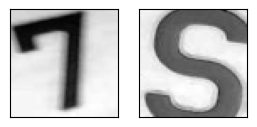

In [6]:
# visualize_dataset(full_dataset)
Sample_visualize(train_dataloader)

In [7]:
model = md.CNN(init_weights=True)
model.to(DEVICE)
print(model)

CNN(
  (localization): Sequential(
    (0): Conv2d(1, 48, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(48, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=9216, out_features=100, bias=True)
    (14): ReLU()
    (15): Linear(in_features=100, out_features=6, bias=True)
    (16): ReLU()
  )

In [8]:
# import torchsummary
#
# torchsummary.summary(model,input_size=(1,128,128))

In [9]:
loss_fn = nn.CrossEntropyLoss().to(DEVICE)

if Optimizer_type == 'ADAM' :
  optimizer = torch.optim.Adam(model.parameters(), lr = Learning_rate, weight_decay = Weight_decay)
elif Optimizer_type == 'SGD' :
  optimizer = torch.optim.SGD(model.parameters(), lr = Learning_rate, weight_decay = Weight_decay)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.2)

In [10]:
## Training function ##
def train(dataloader, model, loss_fn, optimizer):
  for batch_idx, (X,y) in enumerate(dataloader):

    X = X.to(DEVICE)
    y = y.to(DEVICE)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0:
      print('loss: {:.6f} [{}/{}]'.format(loss.item(), batch_idx*len(X), len(dataloader.dataset)))

In [11]:
## Validation function ##
def validation(model, valdata):
  ## Input : trained model, validation data
  ## Output : validation loss

  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for X, y in valdata:
      X, y = X.to(DEVICE), y.to(DEVICE)
      output = model(X)
      val_loss += nn.functional.cross_entropy(output, y, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()
  val_loss /= len(valdata.dataset)
  print('\n***Validation Result***\nAverage loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)\n'.format(val_loss, correct, len(valdata.dataset), 100*correct/len(valdata.dataset)))

In [12]:
def test(model, testdata):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for X, y in testdata:
      X, y = X.to(DEVICE), y.to(DEVICE)
      output = model(X)
      test_loss += nn.functional.cross_entropy(output, y, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()
  test_loss /= len(testdata.dataset)
  print('\n***Test Result***\nAverage loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)\n'.format(test_loss, correct, len(testdata.dataset), 100*correct/len(testdata.dataset)))

In [13]:
## Training Operation ##
start = time.time()
for t in range(epochs):
  print(f"\n[Epoch {t+1}]")
  train(train_dataloader, model, loss_fn, optimizer)
  validation(model, val_dataloader)
print("\nDone!")
end = time.time()

print("Training time: {:.4f}".format(end-start))



[Epoch 1]
loss: 3.583456 [0/28137]
loss: 3.581937 [1280/28137]
loss: 3.580296 [2560/28137]
loss: 3.574789 [3840/28137]
loss: 3.553074 [5120/28137]
loss: 3.561317 [6400/28137]
loss: 3.517924 [7680/28137]
loss: 3.422583 [8960/28137]
loss: 3.406873 [10240/28137]
loss: 3.357132 [11520/28137]
loss: 3.309019 [12800/28137]
loss: 3.231928 [14080/28137]
loss: 3.204044 [15360/28137]
loss: 3.125409 [16640/28137]
loss: 3.054138 [17920/28137]
loss: 3.056072 [19200/28137]
loss: 2.988724 [20480/28137]
loss: 2.952680 [21760/28137]
loss: 3.022579 [23040/28137]
loss: 2.960729 [24320/28137]
loss: 2.986450 [25600/28137]
loss: 2.976393 [26880/28137]

***Validation Result***
Average loss: 2.950520, Accuracy: 2608/3725 (70.0%)


[Epoch 2]
loss: 3.019421 [0/28137]
loss: 2.954722 [1280/28137]
loss: 2.884555 [2560/28137]
loss: 3.030730 [3840/28137]
loss: 2.958452 [5120/28137]
loss: 2.920346 [6400/28137]
loss: 2.900079 [7680/28137]
loss: 2.919972 [8960/28137]
loss: 2.912784 [10240/28137]
loss: 2.932488 [11520/2

In [14]:
## Test operation ##
start = time.time()
test(model, test_dataloader)
end = time.time()
print("Test time: {:.4f}".format(end-start))


***Test Result***
Average loss: 2.631368, Accuracy: 3556/3560 (99.9%)

Test time: 2.5128


In [15]:
torch.save(model, './model_231204_64x64.pt')